In [1]:
import time
start_time = time.time()

# Preparation - Data grouped on forum level

Import the packages and load the data

In [2]:
# Import needed READkages
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns; sns.set()
import glob
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import re
import nltk
from langdetect import detect
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import transformers
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer
from nbpep8.nbpep8 import pep8
from sklearn.metrics.pairwise import cosine_similarity
from linearmodels import PanelOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

In [3]:
#Set the working directory
os.chdir('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Thesis\\')

In [42]:
#Load the results of the content novelty calculation, that were saved as follows:
final_result_df_tfidf = pd.read_csv('Master Thesis Data\\final_result_df_tfidf.csv')
final_result_df_lsi = pd.read_csv('Master Thesis Data\\final_result_df_lsi.csv')
final_result_df_doc2vec = pd.read_csv('Master Thesis Data\\final_result_df_doc2vec.csv')

C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\2983249164.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  final_result_df_tfidf = pd.read_csv('Master Thesis Data\\final_result_df_tfidf.csv')
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\2983249164.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  final_result_df_lsi = pd.read_csv('Master Thesis Data\\final_result_df_lsi.csv')
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\2983249164.py:4: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  final_result_df_doc2vec = pd.read_csv('Master Thesis Data\\final_result_df_doc2vec.csv')


Load the grouped data frames

In [4]:
#Load the estimation data frames
est_grouped_df_week_tag_reduced_NEW = pd.read_csv('Master Thesis Data\\grouped_df_tag_reduced_week_NEW_2.csv')

In [5]:
est_grouped_df_week_tag_reduced_NEW.shape

(781821, 20)

In [8]:
df_desc_read = est_grouped_df_week_tag_reduced_NEW.describe()
df_desc_read.to_excel("desc_agg_read.xlsx")

Important modification - add weeknumber

In [6]:
from datetime import datetime

# Your function to modify a dataframe
def modify_dataframe(df):
      # Extract the start date of each week and convert it to datetime
    df['Week_Start_Date'] = df['Post_Creation_Date'].apply(lambda x: datetime.strptime(x.split('/')[0], '%Y-%m-%d'))

    # Find the minimum date in the DataFrame
    min_date = df['Week_Start_Date'].min()

    # Create a new column 'Week_Number' that calculates the difference in weeks from the minimum date
    df['Week_Number'] = (df['Week_Start_Date'] - min_date).dt.days // 7 + 1

    # Add the interaction term
    df['DiD'] = df['D'] * df['T']
    
    return df


# Create a copy of your dataframe
df = est_grouped_df_week_tag_reduced_NEW.copy()

# Modify the dataframe
est_grouped_df_week_tag_reduced_NEW = modify_dataframe(df)


In [7]:
est_grouped_df_week_tag_reduced_NEW

,tag_combined,Post_Creation_Date,Post_Count,Post_Answer_Count,ari,fre,fk_grade,gunning_fog,D,T,...,Post_View_Count,Post_Score,Response_Scores,Post_Author,Answer_Author,Title_Length,Body_Length,Week_Start_Date,Week_Number,DiD
0,.d.tstypescript,2021-07-26/2021-08-01,1,2,6.1,78.96,4.6,4.34,0.0,0.0,...,161,0,0,1,1,22.0,1152.0,2021-07-26,4,0.0
1,.d.tstypescript,2021-08-09/2021-08-15,1,2,12.2,65.46,9.7,12.23,0.0,0.0,...,7671,11,14,1,1,34.0,850.0,2021-08-09,6,0.0
2,.d.tstypescript,2021-08-23/2021-08-29,1,1,11.9,62.92,10.7,11.40,0.0,0.0,...,899,1,0,1,1,71.0,2336.0,2021-08-23,8,0.0
3,.d.tstypescript,2022-01-24/2022-01-30,1,0,9.8,63.70,8.4,11.40,0.0,1.0,...,42,1,0,1,1,30.0,839.0,2022-01-24,30,0.0
4,.d.tstypescript,2022-02-07/2022-02-13,1,0,3.9,90.46,2.2,2.52,0.0,1.0,...,1090,2,0,1,1,48.0,438.0,2022-02-07,32,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781816,сеть,2022-01-31/2022-02-06,1,1,0.0,206.84,-15.7,0.00,0.0,1.0,...,29,0,1,1,1,55.0,562.0,2022-01-31,31,0.0
781817,сеть,2022-03-21/2022-03-27,1,0,0.0,206.84,-15.7,0.00,0.0,1.0,...,17,0,0,1,1,38.0,551.0,2022-03-21,38,0.0
781818,сеть,2022-08-08/2022-08-14,1,1,0.0,206.84,-15.7,0.00,1.0,0.0,...,30,2,4,1,1,83.0,193.0,2022-08-08,58,0.0
781819,сеть,2022-08-29/2022-09-04,1,0,0.0,206.84,-15.7,0.00,1.0,0.0,...,27,0,0,1,1,26.0,2076.0,2022-08-29,61,0.0


## Average the readability metrics

Columns with different redability metrics:

ari	

fre	 (1-fre)

fk_grade

gunning_fog

smog_index	

coleman_liau_index

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# List of columns to normalize
cols_to_normalize = ['ari', 'fre', 'fk_grade', 'gunning_fog', 'smog_index', 'coleman_liau_index']

# Apply the scaler to the DataFrame
est_grouped_df_week_tag_reduced_NEW[cols_to_normalize] = scaler.fit_transform(est_grouped_df_week_tag_reduced_NEW[cols_to_normalize])

# Invert the 'fre' column
est_grouped_df_week_tag_reduced_NEW['fre'] = 1 - est_grouped_df_week_tag_reduced_NEW['fre']

# Add a new column with the average of the normalized columns
est_grouped_df_week_tag_reduced_NEW['avg_readability'] = est_grouped_df_week_tag_reduced_NEW[cols_to_normalize].mean(axis=1)

Descriptives

In [12]:
df_desc = est_grouped_df_week_tag_reduced_NEW.describe()

In [13]:
df_desc.to_excel("desc_agg.xlsx")

# Choose the data frame

Note that the data ranges from 01-07-2021 to 30-04-2022 and from 01-07-2022 to 30-04-2023. That implies that the weeks 18,19,20,21,22,23,24,25 are not present in the data set.
Weeks 17 and 26 are dropped as they are incomplete

# 8.1 PTA - tag reduced level

## 8.1.1 Post Count

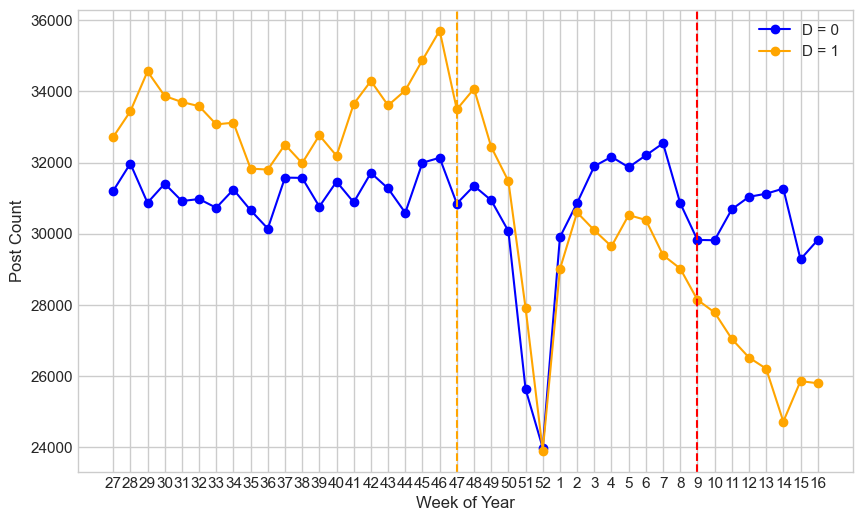

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\3419042351.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\3419042351.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\3419042351.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Count   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):             -0.0358
No. Observations:              781821   R-squared (Within):               0.0034
Date:                Wed, May 31 2023   R-squared (Overall):           8.005e-05
Time:                        16:09:10   Log-likelihood                -1.942e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      31.580
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:               F(41,747440)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             4.6402
                            

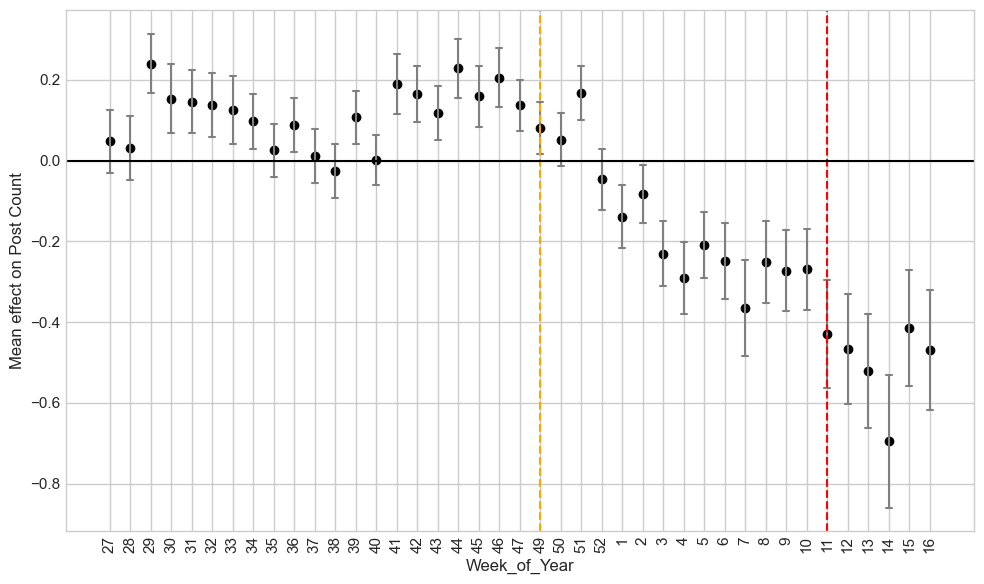

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\3419042351.py:182: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_PC = summary_df_PC.append(additional_stats)


In [81]:
df = est_grouped_df_week_tag_reduced_NEW.copy()

# Create separate dataframes for D=0 and D=1
df_D0 = df[df['D'] == 0]
df_D1 = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped = df_D0.groupby('Week_of_Year')['Post_Count'].sum()
df_D1_grouped = df_D1.groupby('Week_of_Year')['Post_Count'].sum()

# Separate the weeks into two halves
first_half_D0 = df_D0_grouped[df_D0_grouped.index >= 27]
second_half_D0 = df_D0_grouped[df_D0_grouped.index < 27]
df_D0_grouped = pd.concat([first_half_D0, second_half_D0])

first_half_D1 = df_D1_grouped[df_D1_grouped.index >= 27]
second_half_D1 = df_D1_grouped[df_D1_grouped.index < 27]
df_D1_grouped = pd.concat([first_half_D1, second_half_D1])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("")
plt.xlabel("Week of Year")
plt.ylabel("Post Count")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()

#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod = PanelOLS(df.Post_Count, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_PC = mod.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_PC)


# Extract parameters and t-statistics from fe_res_PC
params = fe_res_PC.params[1:]  # Exclude constant
tvalues = fe_res_PC.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr = np.sqrt(np.diag(fe_res_PC.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues = fe_res_PC.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df = pd.DataFrame({"params": params, "stderr": stderr, "tvalues": tvalues, "pvalues": pvalues})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df["lower_ci"] = results_df["params"] - 1.96*results_df["stderr"]
results_df["upper_ci"] = results_df["params"] + 1.96*results_df["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df['Week_of_Year_Idx'] = results_df['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df['Week_of_Year_Idx'], results_df['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df['Week_of_Year_Idx'], results_df['Week_of_Year'], rotation='vertical')

plt.title("")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean effect on Post Count")

plt.tight_layout()
plt.show()

# Creating the summary DataFrame
summary_df_PC = pd.DataFrame({'coefficients': fe_res_PC.params, 'p-values': fe_res_PC.pvalues})

# Assigning the stars
conditions = [
    (summary_df_PC['p-values'] < 0.01),
    (summary_df_PC['p-values'] < 0.05),
    (summary_df_PC['p-values'] < 0.1)
]
choices = ['***', '**', '*']
summary_df_PC['p-value sig.'] = np.select(conditions, choices, default='')

# Round the coefficients to 4 decimal places
summary_df_PC['coefficients'] = summary_df_PC['coefficients'].round(4)

# Concatenating the stars to the coefficients
summary_df_PC['coefficients'] = summary_df_PC['coefficients'].astype(str) + summary_df_PC['p-value sig.']

# Adding F-statistic, its p-value, and R^2
f_statistic = fe_res_PC.f_statistic.stat
f_pvalue = fe_res_PC.f_statistic.pval
r_squared = fe_res_PC.rsquared

# Assigning the stars to F-statistic
f_stat_star = '***' if f_pvalue < 0.01 else '**' if f_pvalue < 0.05 else '*' if f_pvalue < 0.1 else ''

additional_stats = pd.DataFrame({
    'coefficients': [f'{f_statistic}{f_stat_star}', r_squared],
    'p-values': [np.nan, np.nan],
    'p-value sig.': ['', '']
}, index=['F-statistic', 'R-squared'])

summary_df_PC = summary_df_PC.append(additional_stats)

# Add the name of dependent variable as the first row
dep_var_row = pd.DataFrame({
    'coefficients': [fe_res_PC.model.dependent.vars[0]],
    'p-values': [np.nan],
    'p-value sig.': ['']
}, index=['Dependent Variable'])

summary_df_PC = pd.concat([dep_var_row, summary_df_PC])

# Drop the unnecessary columns
summary_df_PC = summary_df_PC.drop(columns=['p-values', 'p-value sig.'])

#To save the summary table to an Excel file
summary_df_PC.to_excel('Results Python\\PTT_regression_summary_PC.xlsx')



## 8.1.2 Post_View_Count

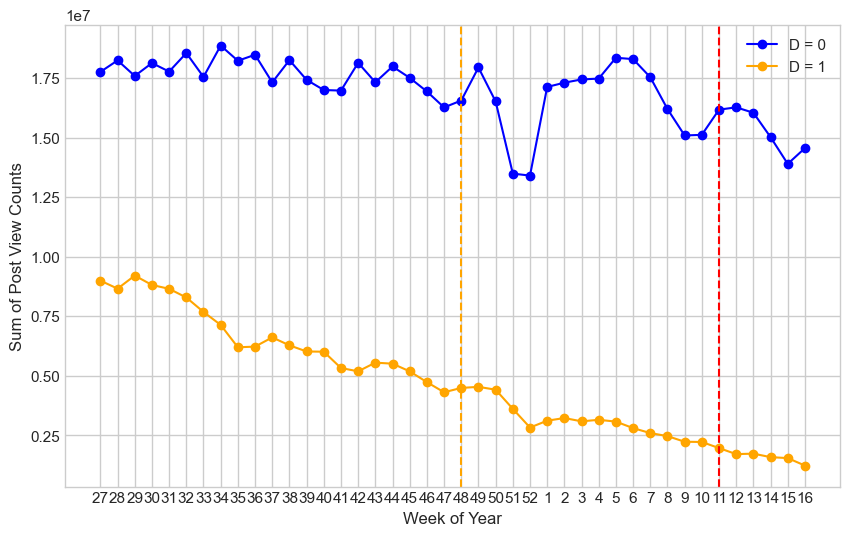

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\647587728.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\647587728.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\647587728.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

                          PanelOLS Estimation Summary                           
Dep. Variable:        Post_View_Count   R-squared:                        0.0141
Estimator:                   PanelOLS   R-squared (Between):             -0.0317
No. Observations:              781821   R-squared (Within):               0.0141
Date:                Wed, May 31 2023   R-squared (Overall):              0.0070
Time:                        16:09:50   Log-likelihood                -7.872e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      261.54
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:               F(41,747440)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             11.175
                            

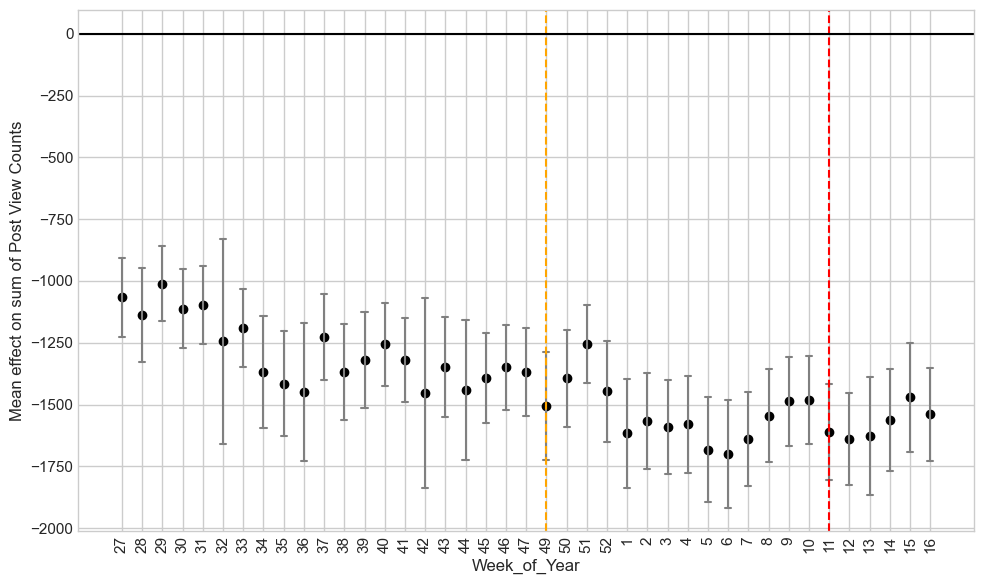

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\647587728.py:182: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_PVC = summary_df_PVC.append(additional_stats)


In [82]:
df = est_grouped_df_week_tag_reduced_NEW.copy()

# Create separate dataframes for D=0 and D=1
df_D0_PVC = df[df['D'] == 0]
df_D1_PVC = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_PVC = df_D0_PVC.groupby('Week_of_Year')['Post_View_Count'].sum()
df_D1_grouped_PVC = df_D1_PVC.groupby('Week_of_Year')['Post_View_Count'].sum()

# Separate the weeks into two halves
first_half_D0_PVC = df_D0_grouped_PVC[df_D0_grouped_PVC.index >= 27]
second_half_D0_PVC = df_D0_grouped_PVC[df_D0_grouped_PVC.index < 27]
df_D0_grouped_PVC = pd.concat([first_half_D0_PVC, second_half_D0_PVC])

first_half_D1_PVC = df_D1_grouped_PVC[df_D1_grouped_PVC.index >= 27]
second_half_D1_PVC = df_D1_grouped_PVC[df_D1_grouped_PVC.index < 27]
df_D1_grouped_PVC = pd.concat([first_half_D1_PVC, second_half_D1_PVC])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_PVC) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_PVC.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_PVC.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("")
plt.xlabel("Week of Year")
plt.ylabel("Sum of Post View Counts")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()


#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_PVC = PanelOLS(df.Post_View_Count, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_PVC = mod_PVC.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_PVC)

# Extract parameters and t-statistics from fe_res
params_PVC = fe_res_PVC.params[1:]  # Exclude constant
tvalues_PVC = fe_res_PVC.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_PVC = np.sqrt(np.diag(fe_res_PVC.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_PVC = fe_res_PVC.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_PVC = pd.DataFrame({"params": params_PVC, "stderr": stderr_PVC, "tvalues": tvalues_PVC, "pvalues": pvalues_PVC})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_PVC["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_PVC["lower_ci"] = results_df_PVC["params"] - 1.96*results_df_PVC["stderr"]
results_df_PVC["upper_ci"] = results_df_PVC["params"] + 1.96*results_df_PVC["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_PVC['Week_of_Year_Idx'] = results_df_PVC['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_PVC.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_PVC['Week_of_Year_Idx'], results_df_PVC['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_PVC.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_PVC.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_PVC['Week_of_Year_Idx'], results_df_PVC['Week_of_Year'], rotation='vertical')

plt.title("")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean effect on sum of Post View Counts")

plt.tight_layout()
plt.show()

# Creating the summary DataFrame
summary_df_PVC = pd.DataFrame({'coefficients': fe_res_PVC.params, 'p-values': fe_res_PVC.pvalues})

# Assigning the stars
conditions = [
    (summary_df_PVC['p-values'] < 0.01),
    (summary_df_PVC['p-values'] < 0.05),
    (summary_df_PVC['p-values'] < 0.1)
]
choices = ['***', '**', '*']
summary_df_PVC['p-value sig.'] = np.select(conditions, choices, default='')

# Round the coefficients to 4 decimal places
summary_df_PVC['coefficients'] = summary_df_PVC['coefficients'].round(4)

# Concatenating the stars to the coefficients
summary_df_PVC['coefficients'] = summary_df_PVC['coefficients'].astype(str) + summary_df_PVC['p-value sig.']

# Adding F-statistic, its p-value, and R^2
f_statistic = fe_res_PVC.f_statistic.stat
f_pvalue = fe_res_PVC.f_statistic.pval
r_squared = fe_res_PVC.rsquared

# Assigning the stars to F-statistic
f_stat_star = '***' if f_pvalue < 0.01 else '**' if f_pvalue < 0.05 else '*' if f_pvalue < 0.1 else ''

additional_stats = pd.DataFrame({
    'coefficients': [f'{f_statistic}{f_stat_star}', r_squared],
    'p-values': [np.nan, np.nan],
    'p-value sig.': ['', '']
}, index=['F-statistic', 'R-squared'])

summary_df_PVC = summary_df_PVC.append(additional_stats)

# Add the name of dependent variable as the first row
dep_var_row = pd.DataFrame({
    'coefficients': [fe_res_PVC.model.dependent.vars[0]],
    'p-values': [np.nan],
    'p-value sig.': ['']
}, index=['Dependent Variable'])

summary_df_PVC = pd.concat([dep_var_row, summary_df_PVC])

# Drop the unnecessary columns
summary_df_PVC = summary_df_PVC.drop(columns=['p-values', 'p-value sig.'])

#To save the summary table to an Excel file
summary_df_PVC.to_excel('Results Python\\PTT_regression_summary_PVC.xlsx')




## 8.1.3 Post_Score

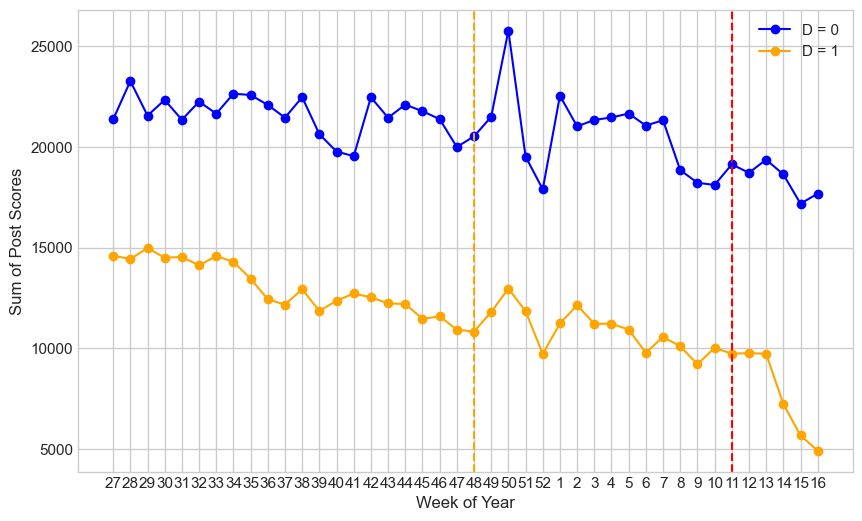

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\2161109771.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\2161109771.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\2161109771.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Score   R-squared:                        0.0085
Estimator:                   PanelOLS   R-squared (Between):             -0.0193
No. Observations:              781821   R-squared (Within):               0.0082
Date:                Wed, May 31 2023   R-squared (Overall):              0.0038
Time:                        16:10:34   Log-likelihood                -2.456e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      155.91
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:               F(41,747440)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             14.297
                            

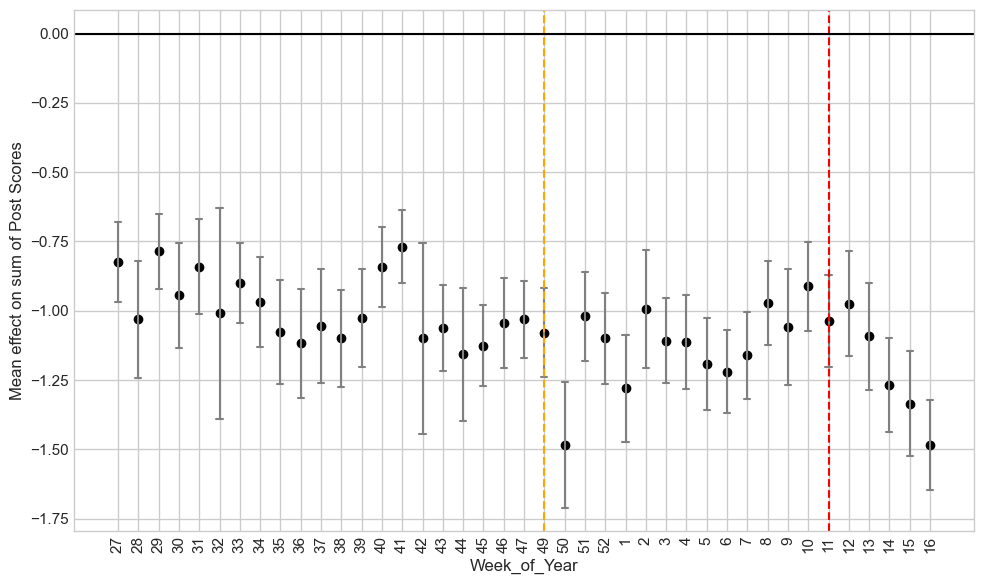

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\2161109771.py:182: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_PS = summary_df_PS.append(additional_stats)


In [83]:
df = est_grouped_df_week_tag_reduced_NEW.copy()

# Create separate dataframes for D=0 and D=1
df_D0_PS = df[df['D'] == 0]
df_D1_PS = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_PS = df_D0_PS.groupby('Week_of_Year')['Post_Score'].sum()
df_D1_grouped_PS = df_D1_PS.groupby('Week_of_Year')['Post_Score'].sum()

# Separate the weeks into two halves
first_half_D0_PS = df_D0_grouped_PS[df_D0_grouped_PS.index >= 27]
second_half_D0_PS = df_D0_grouped_PS[df_D0_grouped_PS.index < 27]
df_D0_grouped_PS = pd.concat([first_half_D0_PS, second_half_D0_PS])

first_half_D1_PS = df_D1_grouped_PS[df_D1_grouped_PS.index >= 27]
second_half_D1_PS = df_D1_grouped_PS[df_D1_grouped_PS.index < 27]
df_D1_grouped_PS = pd.concat([first_half_D1_PS, second_half_D1_PS])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_PS) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_PS.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_PS.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("")
plt.xlabel("Week of Year")
plt.ylabel("Sum of Post Scores")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()


#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_PS = PanelOLS(df.Post_Score, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_PS = mod_PS.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_PS)

# Extract parameters and t-statistics from fe_res
params_PS = fe_res_PS.params[1:]  # Exclude constant
tvalues_PS = fe_res_PS.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_PS = np.sqrt(np.diag(fe_res_PS.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_PS = fe_res_PS.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_PS = pd.DataFrame({"params": params_PS, "stderr": stderr_PS, "tvalues": tvalues_PS, "pvalues": pvalues_PS})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_PS["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_PS["lower_ci"] = results_df_PS["params"] - 1.96*results_df_PS["stderr"]
results_df_PS["upper_ci"] = results_df_PS["params"] + 1.96*results_df_PS["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_PS['Week_of_Year_Idx'] = results_df_PS['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_PS.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_PS['Week_of_Year_Idx'], results_df_PS['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_PS.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_PS.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_PS['Week_of_Year_Idx'], results_df_PS['Week_of_Year'], rotation='vertical')

plt.title("")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean effect on sum of Post Scores")

plt.tight_layout()
plt.show()

# Creating the summary DataFrame
summary_df_PS = pd.DataFrame({'coefficients': fe_res_PS.params, 'p-values': fe_res_PS.pvalues})

# Assigning the stars
conditions = [
    (summary_df_PS['p-values'] < 0.01),
    (summary_df_PS['p-values'] < 0.05),
    (summary_df_PS['p-values'] < 0.1)
]
choices = ['***', '**', '*']
summary_df_PS['p-value sig.'] = np.select(conditions, choices, default='')

# Round the coefficients to 4 decimal places
summary_df_PS['coefficients'] = summary_df_PS['coefficients'].round(4)

# Concatenating the stars to the coefficients
summary_df_PS['coefficients'] = summary_df_PS['coefficients'].astype(str) + summary_df_PS['p-value sig.']

# Adding F-statistic, its p-value, and R^2
f_statistic = fe_res_PS.f_statistic.stat
f_pvalue = fe_res_PS.f_statistic.pval
r_squared = fe_res_PS.rsquared

# Assigning the stars to F-statistic
f_stat_star = '***' if f_pvalue < 0.01 else '**' if f_pvalue < 0.05 else '*' if f_pvalue < 0.1 else ''

additional_stats = pd.DataFrame({
    'coefficients': [f'{f_statistic}{f_stat_star}', r_squared],
    'p-values': [np.nan, np.nan],
    'p-value sig.': ['', '']
}, index=['F-statistic', 'R-squared'])

summary_df_PS = summary_df_PS.append(additional_stats)

# Add the name of dependent variable as the first row
dep_var_row = pd.DataFrame({
    'coefficients': [fe_res_PS.model.dependent.vars[0]],
    'p-values': [np.nan],
    'p-value sig.': ['']
}, index=['Dependent Variable'])

summary_df_PS = pd.concat([dep_var_row, summary_df_PS])

# Drop the unnecessary columns
summary_df_PS = summary_df_PS.drop(columns=['p-values', 'p-value sig.'])

#To save the summary table to an Excel file
summary_df_PS.to_excel('Results Python\\PTT_regression_summary_PS.xlsx')



## 8.1.4 Post_Answer_Count

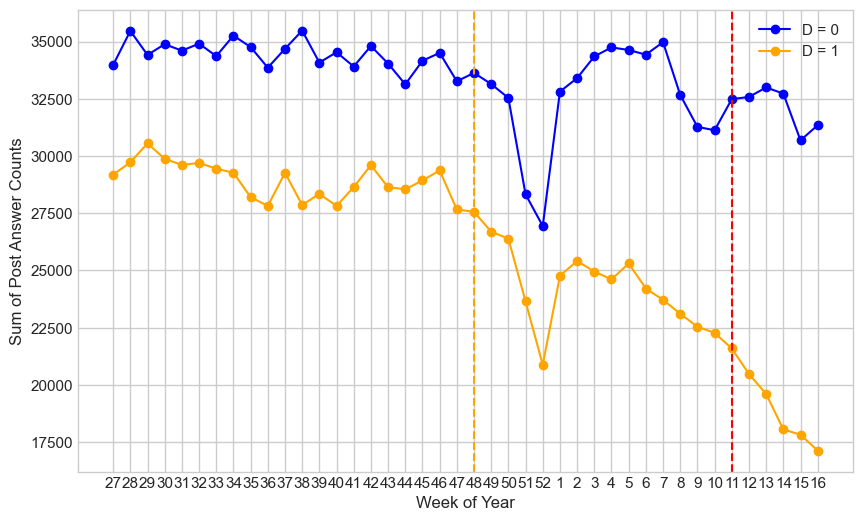

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\226564047.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\226564047.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\226564047.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

                          PanelOLS Estimation Summary                           
Dep. Variable:      Post_Answer_Count   R-squared:                        0.0096
Estimator:                   PanelOLS   R-squared (Between):             -0.0286
No. Observations:              781821   R-squared (Within):               0.0110
Date:                Wed, May 31 2023   R-squared (Overall):              0.0008
Time:                        16:11:16   Log-likelihood                -2.294e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      177.53
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:               F(41,747440)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             9.5938
                            

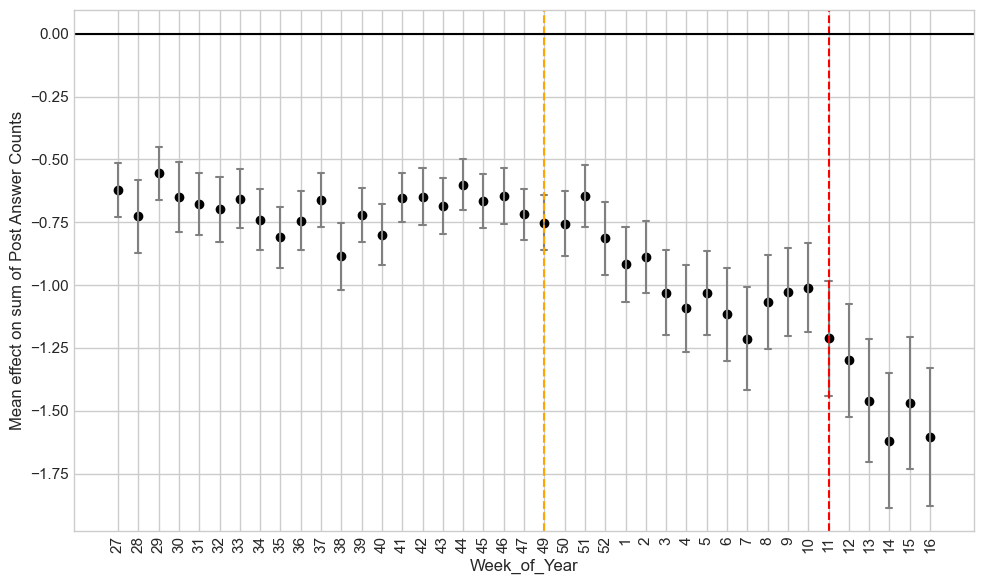

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\226564047.py:181: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_PAC = summary_df_PAC.append(additional_stats)


In [84]:
df = est_grouped_df_week_tag_reduced_NEW.copy()

# Create separate dataframes for D=0 and D=1
df_D0_PAC = df[df['D'] == 0]
df_D1_PAC = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_PAC = df_D0_PAC.groupby('Week_of_Year')['Post_Answer_Count'].sum()
df_D1_grouped_PAC = df_D1_PAC.groupby('Week_of_Year')['Post_Answer_Count'].sum()

# Separate the weeks into two halves
first_half_D0_PAC = df_D0_grouped_PAC[df_D0_grouped_PAC.index >= 27]
second_half_D0_PAC = df_D0_grouped_PAC[df_D0_grouped_PAC.index < 27]
df_D0_grouped_PAC = pd.concat([first_half_D0_PAC, second_half_D0_PAC])

first_half_D1_PAC = df_D1_grouped_PAC[df_D1_grouped_PAC.index >= 27]
second_half_D1_PAC = df_D1_grouped_PAC[df_D1_grouped_PAC.index < 27]
df_D1_grouped_PAC = pd.concat([first_half_D1_PAC, second_half_D1_PAC])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_PAC) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_PAC.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_PAC.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("")
plt.xlabel("Week of Year")
plt.ylabel("Sum of Post Answer Counts")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()

#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_PAC = PanelOLS(df.Post_Answer_Count, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_PAC = mod_PAC.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_PAC)

# Extract parameters and t-statistics from fe_res
params_PAC = fe_res_PAC.params[1:]  # Exclude constant
tvalues_PAC = fe_res_PAC.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_PAC = np.sqrt(np.diag(fe_res_PAC.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_PAC = fe_res_PAC.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_PAC = pd.DataFrame({"params": params_PAC, "stderr": stderr_PAC, "tvalues": tvalues_PAC, "pvalues": pvalues_PAC})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_PAC["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_PAC["lower_ci"] = results_df_PAC["params"] - 1.96*results_df_PAC["stderr"]
results_df_PAC["upper_ci"] = results_df_PAC["params"] + 1.96*results_df_PAC["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_PAC['Week_of_Year_Idx'] = results_df_PAC['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_PAC.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_PAC['Week_of_Year_Idx'], results_df_PAC['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_PAC.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_PAC.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_PAC['Week_of_Year_Idx'], results_df_PAC['Week_of_Year'], rotation='vertical')

plt.title("")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean effect on sum of Post Answer Counts")

plt.tight_layout()
plt.show()

# Creating the summary DataFrame
summary_df_PAC = pd.DataFrame({'coefficients': fe_res_PAC.params, 'p-values': fe_res_PAC.pvalues})

# Assigning the stars
conditions = [
    (summary_df_PAC['p-values'] < 0.01),
    (summary_df_PAC['p-values'] < 0.05),
    (summary_df_PAC['p-values'] < 0.1)
]
choices = ['***', '**', '*']
summary_df_PAC['p-value sig.'] = np.select(conditions, choices, default='')

# Round the coefficients to 4 decimal places
summary_df_PAC['coefficients'] = summary_df_PAC['coefficients'].round(4)

# Concatenating the stars to the coefficients
summary_df_PAC['coefficients'] = summary_df_PAC['coefficients'].astype(str) + summary_df_PAC['p-value sig.']

# Adding F-statistic, its p-value, and R^2
f_statistic = fe_res_PAC.f_statistic.stat
f_pvalue = fe_res_PAC.f_statistic.pval
r_squared = fe_res_PAC.rsquared

# Assigning the stars to F-statistic
f_stat_star = '***' if f_pvalue < 0.01 else '**' if f_pvalue < 0.05 else '*' if f_pvalue < 0.1 else ''

additional_stats = pd.DataFrame({
    'coefficients': [f'{f_statistic}{f_stat_star}', r_squared],
    'p-values': [np.nan, np.nan],
    'p-value sig.': ['', '']
}, index=['F-statistic', 'R-squared'])

summary_df_PAC = summary_df_PAC.append(additional_stats)

# Add the name of dependent variable as the first row
dep_var_row = pd.DataFrame({
    'coefficients': [fe_res_PAC.model.dependent.vars[0]],
    'p-values': [np.nan],
    'p-value sig.': ['']
}, index=['Dependent Variable'])

summary_df_PAC = pd.concat([dep_var_row, summary_df_PAC])

# Drop the unnecessary columns
summary_df_PAC = summary_df_PAC.drop(columns=['p-values', 'p-value sig.'])

#To save the summary table to an Excel file
summary_df_PAC.to_excel('Results Python\\PTT_regression_summary_PAC.xlsx')



## 8.1.5 Response_Scores	

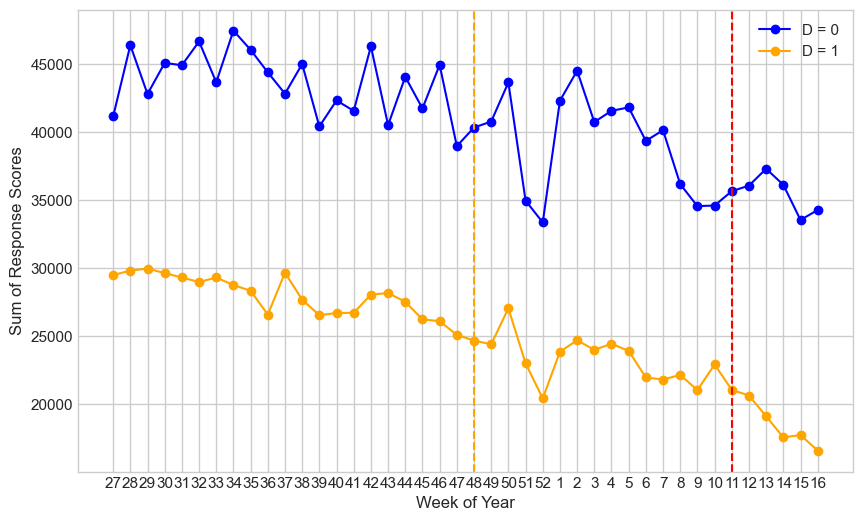

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\1815180468.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\1815180468.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\1815180468.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

                          PanelOLS Estimation Summary                           
Dep. Variable:        Response_Scores   R-squared:                        0.0040
Estimator:                   PanelOLS   R-squared (Between):             -0.0200
No. Observations:              781821   R-squared (Within):               0.0037
Date:                Wed, May 31 2023   R-squared (Overall):              0.0020
Time:                        16:12:00   Log-likelihood                -3.141e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      73.908
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:               F(41,747440)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             10.156
                            

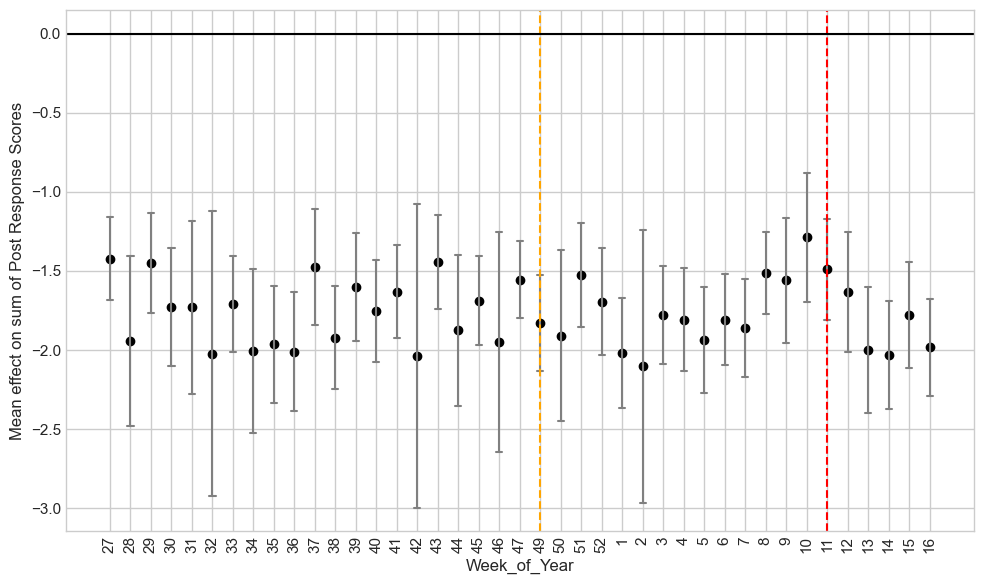

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\1815180468.py:181: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_RS = summary_df_RS.append(additional_stats)


In [85]:
df = est_grouped_df_week_tag_reduced_NEW.copy()

# Create separate dataframes for D=0 and D=1
df_D0_RS = df[df['D'] == 0]
df_D1_RS = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_RS = df_D0_RS.groupby('Week_of_Year')['Response_Scores'].sum()
df_D1_grouped_RS = df_D1_RS.groupby('Week_of_Year')['Response_Scores'].sum()

# Separate the weeks into two halves
first_half_D0_RS = df_D0_grouped_RS[df_D0_grouped_RS.index >= 27]
second_half_D0_RS = df_D0_grouped_RS[df_D0_grouped_RS.index < 27]
df_D0_grouped_RS = pd.concat([first_half_D0_RS, second_half_D0_RS])

first_half_D1_RS = df_D1_grouped_RS[df_D1_grouped_RS.index >= 27]
second_half_D1_RS = df_D1_grouped_RS[df_D1_grouped_RS.index < 27]
df_D1_grouped_RS = pd.concat([first_half_D1_RS, second_half_D1_RS])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_RS) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_RS.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_RS.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("")
plt.xlabel("Week of Year")
plt.ylabel("Sum of Response Scores")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()

#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_RS = PanelOLS(df.Response_Scores, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_RS = mod_RS.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_RS)

# Extract parameters and t-statistics from fe_res
params_RS = fe_res_RS.params[1:]  # Exclude constant
tvalues_RS = fe_res_RS.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_RS = np.sqrt(np.diag(fe_res_RS.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_RS = fe_res_RS.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_RS = pd.DataFrame({"params": params_RS, "stderr": stderr_RS, "tvalues": tvalues_RS, "pvalues": pvalues_RS})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_RS["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_RS["lower_ci"] = results_df_RS["params"] - 1.96*results_df_RS["stderr"]
results_df_RS["upper_ci"] = results_df_RS["params"] + 1.96*results_df_RS["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_RS['Week_of_Year_Idx'] = results_df_RS['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_RS.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_RS['Week_of_Year_Idx'], results_df_RS['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_RS.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_RS.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_RS['Week_of_Year_Idx'], results_df_RS['Week_of_Year'], rotation='vertical')

plt.title("")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean effect on sum of Post Response Scores")

plt.tight_layout()
plt.show()

# Creating the summary DataFrame
summary_df_RS = pd.DataFrame({'coefficients': fe_res_RS.params, 'p-values': fe_res_RS.pvalues})

# Assigning the stars
conditions = [
    (summary_df_RS['p-values'] < 0.01),
    (summary_df_RS['p-values'] < 0.05),
    (summary_df_RS['p-values'] < 0.1)
]
choices = ['***', '**', '*']
summary_df_RS['p-value sig.'] = np.select(conditions, choices, default='')

# Round the coefficients to 4 decimal places
summary_df_RS['coefficients'] = summary_df_RS['coefficients'].round(4)

# Concatenating the stars to the coefficients
summary_df_RS['coefficients'] = summary_df_RS['coefficients'].astype(str) + summary_df_RS['p-value sig.']

# Adding F-statistic, its p-value, and R^2
f_statistic = fe_res_RS.f_statistic.stat
f_pvalue = fe_res_RS.f_statistic.pval
r_squared = fe_res_RS.rsquared

# Assigning the stars to F-statistic
f_stat_star = '***' if f_pvalue < 0.01 else '**' if f_pvalue < 0.05 else '*' if f_pvalue < 0.1 else ''

additional_stats = pd.DataFrame({
    'coefficients': [f'{f_statistic}{f_stat_star}', r_squared],
    'p-values': [np.nan, np.nan],
    'p-value sig.': ['', '']
}, index=['F-statistic', 'R-squared'])

summary_df_RS = summary_df_RS.append(additional_stats)

# Add the name of dependent variable as the first row
dep_var_row = pd.DataFrame({
    'coefficients': [fe_res_RS.model.dependent.vars[0]],
    'p-values': [np.nan],
    'p-value sig.': ['']
}, index=['Dependent Variable'])

summary_df_RS = pd.concat([dep_var_row, summary_df_RS])

# Drop the unnecessary columns
summary_df_RS = summary_df_RS.drop(columns=['p-values', 'p-value sig.'])

#To save the summary table to an Excel file
summary_df_RS.to_excel('Results Python\\PTT_regression_summary_RS.xlsx')




## 8.1.6 Average Readability

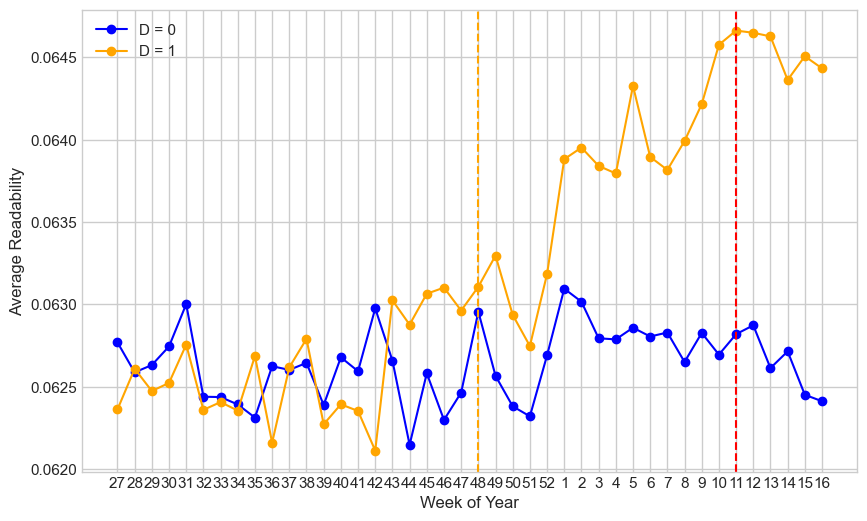

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\842329161.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\842329161.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\842329161.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

                          PanelOLS Estimation Summary                           
Dep. Variable:        avg_readability   R-squared:                        0.0008
Estimator:                   PanelOLS   R-squared (Between):             -0.0009
No. Observations:              781821   R-squared (Within):               0.0013
Date:                Wed, May 31 2023   R-squared (Overall):              0.0011
Time:                        16:12:46   Log-likelihood                 2.153e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      15.275
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:               F(41,747440)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             14.203
                            

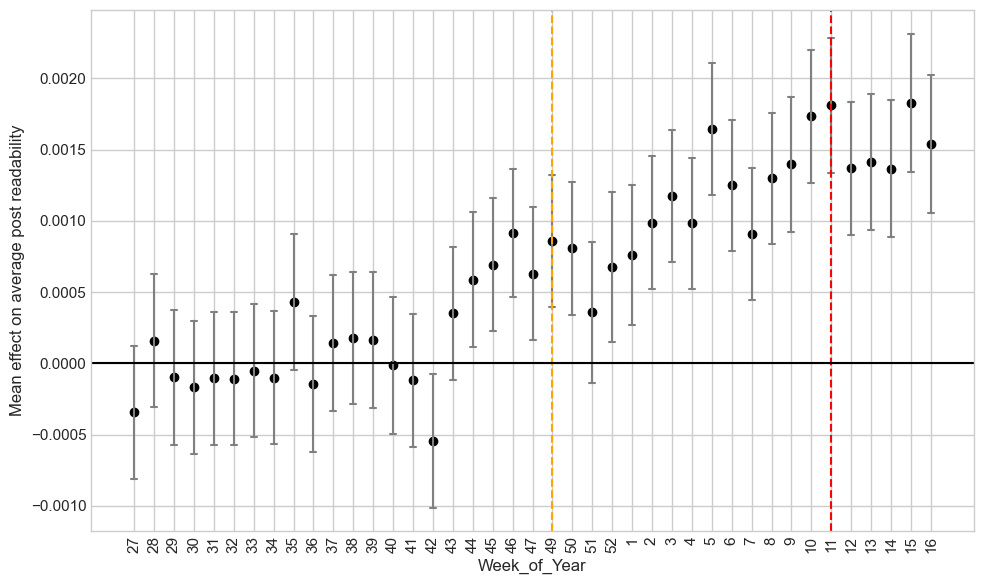

C:\Users\piotr\AppData\Local\Temp\ipykernel_17996\842329161.py:182: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_READ = summary_df_READ.append(additional_stats)


In [86]:
df = est_grouped_df_week_tag_reduced_NEW.copy()

# Create separate dataframes for D=0 and D=1
df_D0_READ = df[df['D'] == 0]
df_D1_READ = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_READ = df_D0_READ.groupby('Week_of_Year')['avg_readability'].mean()
df_D1_grouped_READ = df_D1_READ.groupby('Week_of_Year')['avg_readability'].mean()

# Separate the weeks into two halves
first_half_D0_READ = df_D0_grouped_READ[df_D0_grouped_READ.index >= 27]
second_half_D0_READ = df_D0_grouped_READ[df_D0_grouped_READ.index < 27]
df_D0_grouped_READ = pd.concat([first_half_D0_READ, second_half_D0_READ])

first_half_D1_READ = df_D1_grouped_READ[df_D1_grouped_READ.index >= 27]
second_half_D1_READ = df_D1_grouped_READ[df_D1_grouped_READ.index < 27]
df_D1_grouped_READ = pd.concat([first_half_D1_READ, second_half_D1_READ])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_READ) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_READ.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_READ.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("")
plt.xlabel("Week of Year")
plt.ylabel("Average Readability")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()

#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_READ = PanelOLS(df.avg_readability, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_READ = mod_READ.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_READ)

# Extract parameters and t-statistics from fe_res
params_READ = fe_res_READ.params[1:]  # Exclude constant
tvalues_READ = fe_res_READ.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_READ = np.sqrt(np.diag(fe_res_READ.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_READ = fe_res_READ.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_READ = pd.DataFrame({"params": params_READ, "stderr": stderr_READ, "tvalues": tvalues_READ, "pvalues": pvalues_READ})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_READ["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_READ["lower_ci"] = results_df_READ["params"] - 1.96*results_df_READ["stderr"]
results_df_READ["upper_ci"] = results_df_READ["params"] + 1.96*results_df_READ["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_READ['Week_of_Year_Idx'] = results_df_READ['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_READ.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_READ['Week_of_Year_Idx'], results_df_READ['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_READ.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_READ.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_READ['Week_of_Year_Idx'], results_df_READ['Week_of_Year'], rotation='vertical')

plt.title("")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean effect on average post readability")

plt.tight_layout()
plt.show()

# Creating the summary DataFrame
summary_df_READ = pd.DataFrame({'coefficients': fe_res_READ.params, 'p-values': fe_res_READ.pvalues})

# Assigning the stars
conditions = [
    (summary_df_READ['p-values'] < 0.01),
    (summary_df_READ['p-values'] < 0.05),
    (summary_df_READ['p-values'] < 0.1)
]
choices = ['***', '**', '*']
summary_df_READ['p-value sig.'] = np.select(conditions, choices, default='')

# Round the coefficients to 4 decimal places
summary_df_READ['coefficients'] = summary_df_READ['coefficients'].round(4)


# Concatenating the stars to the coefficients
summary_df_READ['coefficients'] = summary_df_READ['coefficients'].astype(str) + summary_df_READ['p-value sig.']

# Adding F-statistic, its p-value, and R^2
f_statistic = fe_res_READ.f_statistic.stat
f_pvalue = fe_res_READ.f_statistic.pval
r_squared = fe_res_READ.rsquared

# Assigning the stars to F-statistic
f_stat_star = '***' if f_pvalue < 0.01 else '**' if f_pvalue < 0.05 else '*' if f_pvalue < 0.1 else ''

additional_stats = pd.DataFrame({
    'coefficients': [f'{f_statistic}{f_stat_star}', r_squared],
    'p-values': [np.nan, np.nan],
    'p-value sig.': ['', '']
}, index=['F-statistic', 'R-squared'])

summary_df_READ = summary_df_READ.append(additional_stats)

# Add the name of dependent variable as the first row
dep_var_row = pd.DataFrame({
    'coefficients': [fe_res_READ.model.dependent.vars[0]],
    'p-values': [np.nan],
    'p-value sig.': ['']
}, index=['Dependent Variable'])

summary_df_READ = pd.concat([dep_var_row, summary_df_READ])

# Drop the unnecessary columns
summary_df_READ = summary_df_READ.drop(columns=['p-values', 'p-value sig.'])

#To save the summary table to an Excel file
summary_df_READ.to_excel('Results Python\\PTT_regression_summary_READ.xlsx')





In [87]:
#merge summary_df_PC, summary_df_PVC, summary_df_PS, summary_df_PAC, summary_df_RS, summary_df_READ
summary_df_PTT = pd.concat([summary_df_PC, summary_df_PVC, summary_df_PS, summary_df_PAC, summary_df_RS, summary_df_READ], axis=1)

# Set the new column labels
summary_df_PTT.columns = summary_df_PTT.iloc[0]

# Drop the second row
summary_df_PTT = summary_df_PTT.drop(summary_df_PTT.index[0])

# Split DataFrame into four parts
first_row = summary_df_PTT.iloc[:1]
first_part = summary_df_PTT.iloc[17:-2]
middle_part = summary_df_PTT.iloc[1:16]
last_part = summary_df_PTT.iloc[-2:]

# Concatenate DataFrame parts in new order
summary_df_PTT = pd.concat([first_row, first_part, middle_part, last_part])

#Save to excel
summary_df_PTT.to_excel('Results Python\\PTT_regression_summary_ALL.xlsx')

summary_df_PTT




Dependent Variable,Post_Count,Post_View_Count,Post_Score,Post_Answer_Count,Response_Scores,avg_readability
const,3.3466***,1871.1266***,2.2743***,3.6335***,4.431***,0.0626***
Week_of_Year_27_D,0.0477,-1065.6795***,-0.8235***,-0.6223***,-1.4228***,-0.0003
Week_of_Year_28_D,0.0319,-1137.6325***,-1.0315***,-0.7263***,-1.9424***,0.0002
Week_of_Year_29_D,0.2405***,-1010.86***,-0.786***,-0.556***,-1.4484***,-0.0001
Week_of_Year_30_D,0.1537***,-1112.533***,-0.9448***,-0.6482***,-1.7271***,-0.0002
Week_of_Year_31_D,0.1459***,-1096.4072***,-0.8413***,-0.677***,-1.73***,-0.0001
Week_of_Year_32_D,0.1385***,-1243.6643***,-1.0087***,-0.6976***,-2.0223***,-0.0001
Week_of_Year_33_D,0.1264***,-1191.911***,-0.9004***,-0.6568***,-1.7091***,-0.0001
Week_of_Year_34_D,0.0972***,-1369.6965***,-0.9693***,-0.7397***,-2.0074***,-0.0001
Week_of_Year_35_D,0.0262,-1415.5293***,-1.0759***,-0.8095***,-1.9635***,0.0004*


# 8.2 DiD regressions - data aggregated at tag level

Only weekly level. Estimations for tag-reduced-week data frames

### Choose the data frame!

In [20]:
# Load the data
data = est_grouped_df_week_tag_reduced_NEW.copy()
#Set the index for fixed effects
data = data.set_index(['tag_combined', 'Week_of_Year'])

Now we are ready for estimations! - choose control variables

In [12]:
X = data[['DiD', 'D', 'T']]
X_Controls = data[['DiD', 'D', 'T', 'Body_Length', 'Title_Length']]

### Correlation matrix of the controls

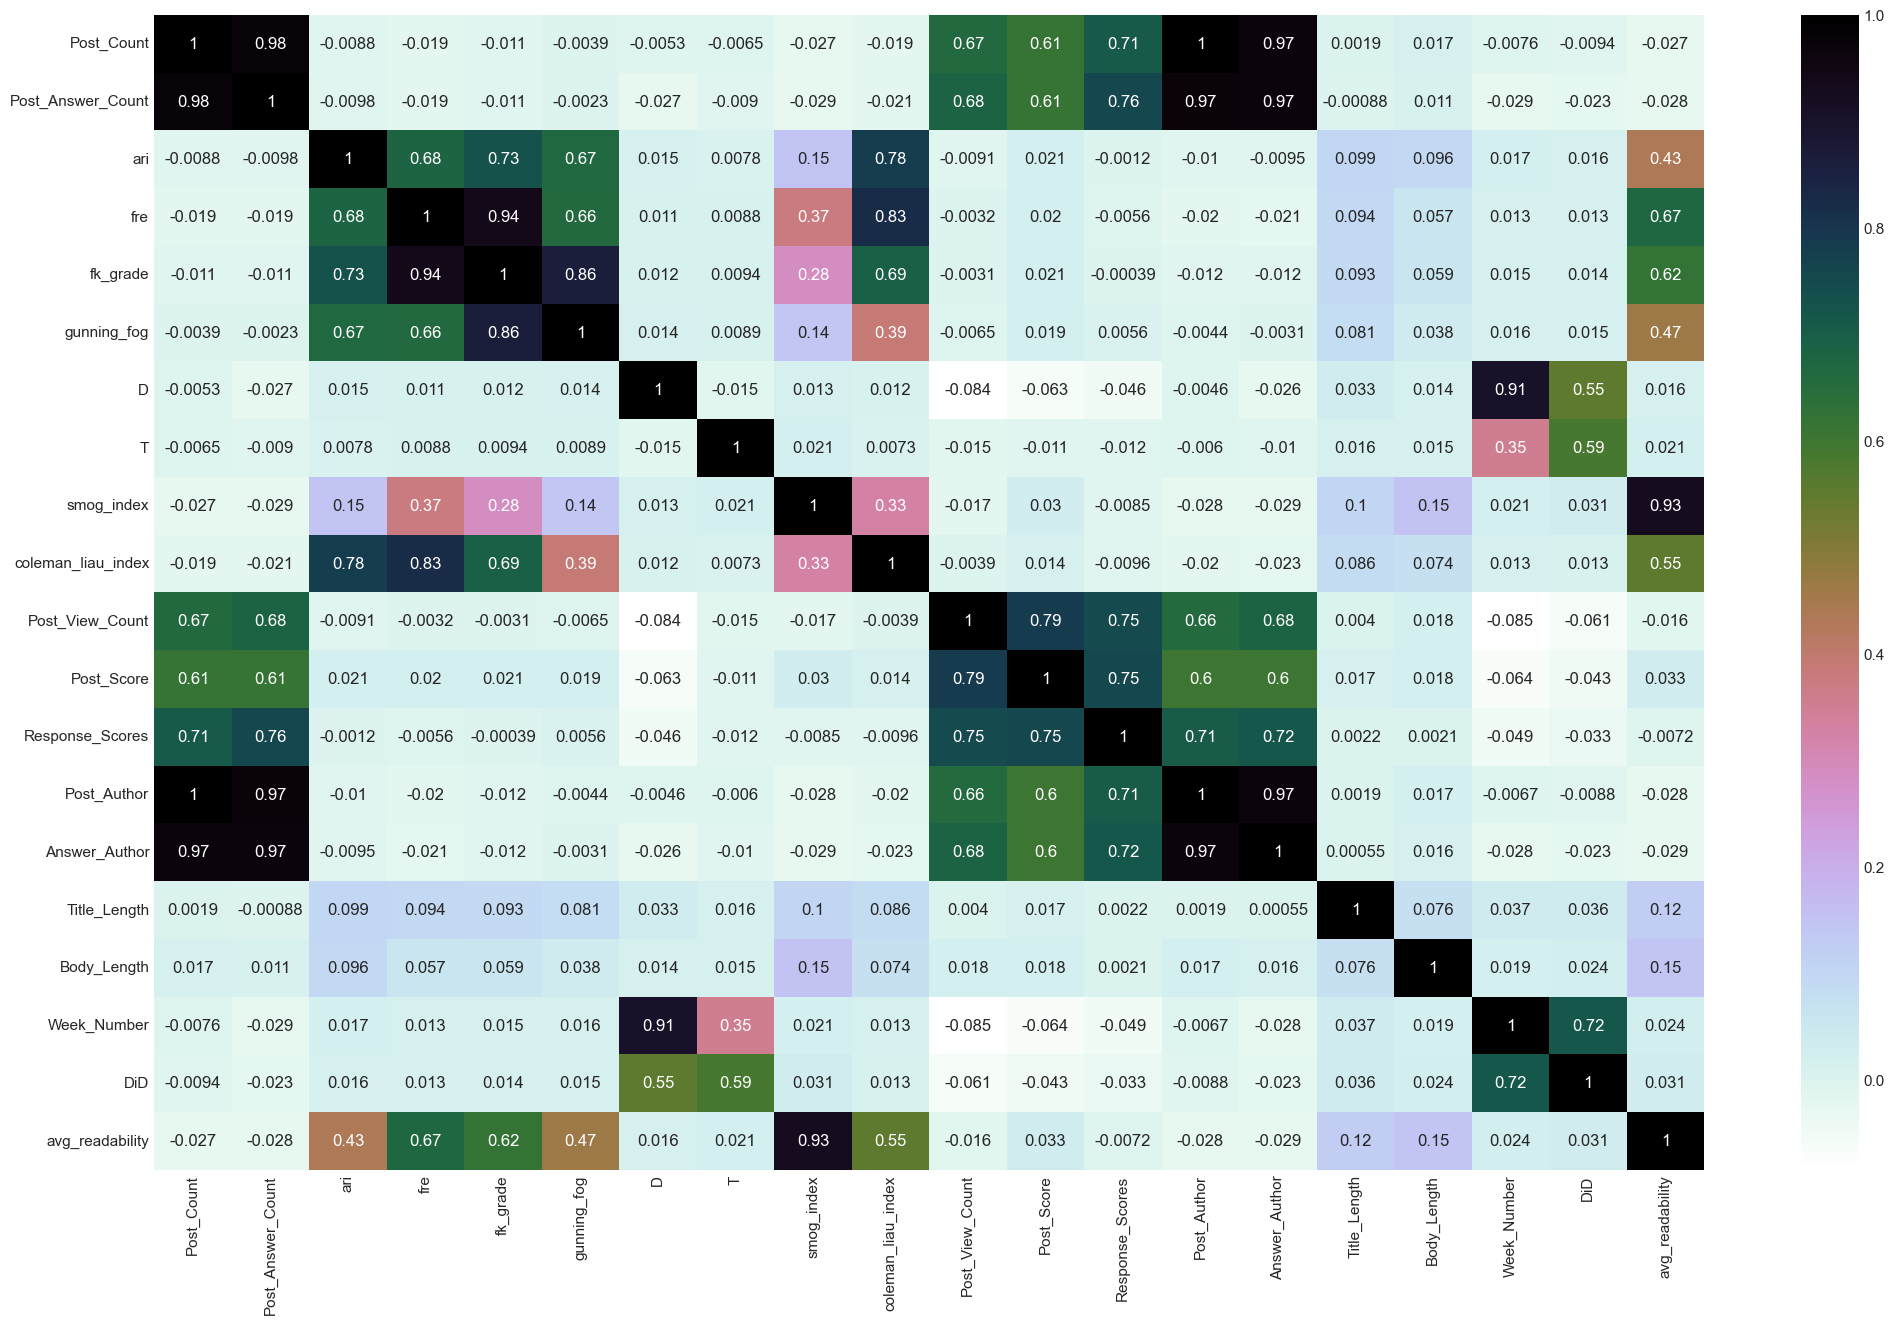

In [13]:
plt.figure(figsize=(25,15)) 
sns.heatmap(data.corr(),annot=True,cmap='cubehelix_r')
plt.show()

### 8.2.1 Post Count

In [26]:
def generate_summary(result):
    # Creating the summary DataFrame
    summary_df = pd.DataFrame({'coefficients': result.params, 'std_errors': result.std_errors, 'p-values': result.pvalues})

    # Assigning the stars
    conditions = [
        (summary_df['p-values'] < 0.01),
        (summary_df['p-values'] < 0.05),
        (summary_df['p-values'] < 0.1),
    ]
    choices = ['***', '**', '*']
    summary_df['p-value sig.'] = np.select(conditions, choices, default='')

    # Round the coefficients and std_errors to 4 decimal places
    summary_df['coefficients'] = summary_df['coefficients'].round(4)
    summary_df['std_errors'] = summary_df['std_errors'].round(4)

    # Concatenating the stars to the coefficients, and std_errors in parentheses
    summary_df['coefficients'] = summary_df['coefficients'].astype(str) + summary_df['p-value sig.'] + " (" + summary_df['std_errors'].astype(str) + ")"

    # Drop the unnecessary columns
    summary_df = summary_df.drop(columns=['std_errors', 'p-values', 'p-value sig.'])

    # Adding F-statistic, its p-value, and R^2
    f_statistic = result.f_statistic.stat
    f_pvalue = result.f_statistic.pval
    r_squared = result.rsquared

    # Assigning the stars to F-statistic
    f_stat_star = '***' if f_pvalue < 0.01 else '**' if f_pvalue < 0.05 else '*' if f_pvalue < 0.1 else ''

    additional_stats = pd.DataFrame({
        'coefficients': [f'{round(f_statistic, 4)}{f_stat_star}', round(r_squared, 4)],
    }, index=['F-statistic', 'R-squared'])

    summary_df = summary_df.append(additional_stats)

    # Add the name of dependent variable as the first row
    dep_var_row = pd.DataFrame({
        'coefficients': [result.model.dependent.vars[0]],
    }, index=['Dependent Variable'])
    
    summary_df = pd.concat([dep_var_row, summary_df])
    
    return summary_df


In [19]:
# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PC_FE_T = PanelOLS(data.Post_Count, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_PC_FE_T = FE_PC_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
              # cluster_time=True
            )

# Regression - FX for Forum/Tag_combined and FX for Weeks + controls
FE_PC_FE_T_controls  = PanelOLS(data.Post_Count, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PC_FE_T_controls = FE_PC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
              # cluster_time=True
             )

# Results
print(result_PC_FE_T)
print(result_PC_FE_T_controls)

# Generate summaries for both models
summary_df_PC_FE_T = generate_summary(result_PC_FE_T)
summary_df_PC_FE_T_controls = generate_summary(result_PC_FE_T_controls)





                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Count   R-squared:                        0.0010
Estimator:                   PanelOLS   R-squared (Between):              0.0025
No. Observations:              781821   R-squared (Within):               0.0013
Date:                Thu, Jun 01 2023   R-squared (Overall):              0.0013
Time:                        15:52:03   Log-likelihood                -1.943e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      252.87
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:                F(3,747478)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             6.4021
                            

In [29]:
# Regression - null model, no FX

Poisson_model_PC = sm.GLM(data.Post_Count, X, family=sm.families.Poisson())
result_Poisson_PC = Poisson_model_PC.fit(cov_type='HC0')

Poisson_model_PC_controls = sm.GLM(data.Post_Count, X_Controls, family=sm.families.Poisson())
result_Poisson_PC_controls = Poisson_model_PC_controls.fit(cov_type='HC0')

print(result_Poisson_PC.summary())
print(result_Poisson_PC_controls.summary())


#fepois - R package

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan

# Subset the DataFrame to only include predictor variables
df_predictors = X_Controls

# Add a constant term to your DataFrame. This is necessary for calculating VIF
df_predictors = add_constant(df_predictors)

# Calculate the VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = df_predictors.columns
vif["VIF"] = [variance_inflation_factor(df_predictors.values, i) for i in range(df_predictors.shape[1])]

print(vif)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Post_Count   No. Observations:               781821
Model:                            GLM   Df Residuals:                   781818
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.7602e+06
Date:                Thu, 01 Jun 2023   Deviance:                   7.6102e+06
Time:                        16:05:48   Pearson chi2:                 9.74e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             -1.422
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DiD           -1.3231      0.018    -72.680      0.0

### 8.2.2 Post View Count

In [30]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PVC_FE_T = PanelOLS(data.Post_View_Count, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_PVC_FE_T = FE_PVC_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PVC_FE_T_controls  = PanelOLS(data.Post_View_Count, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PVC_FE_T_controls = FE_PVC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_PVC_FE_T)
print(result_PVC_FE_T_controls)

# Generate summaries for both models
summary_df_PVC_FE_T = generate_summary(result_PVC_FE_T)
summary_df_PVC_FE_T_controls = generate_summary(result_PVC_FE_T_controls)



# # Regression - null model, no FX

# Poisson_model_PVC = sm.GLM(data.Post_View_Count, X, family=sm.families.Poisson())
# result_Poisson_PVC = Poisson_model_PVC.fit(cov_type='HC0')

# Poisson_model_PVC_controls = sm.GLM(data.Post_View_Count, X_Controls, family=sm.families.Poisson())
# result_Poisson_PVC_controls = Poisson_model_PVC_controls.fit(cov_type='HC0')

# print(result_Poisson_PVC.summary())
# print(result_Poisson_PVC_controls.summary())


                          PanelOLS Estimation Summary                           
Dep. Variable:        Post_View_Count   R-squared:                        0.0144
Estimator:                   PanelOLS   R-squared (Between):             -0.1272
No. Observations:              781821   R-squared (Within):               0.0142
Date:                Thu, Jun 01 2023   R-squared (Overall):             -0.0215
Time:                        16:09:00   Log-likelihood                -7.872e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3631.9
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:                F(3,747478)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             100.04
                            

C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)


### 8.2.3 Post_Score

In [31]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PS_FE_T = PanelOLS(data.Post_Score, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_PS_FE_T = FE_PS_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PS_FE_T_controls  = PanelOLS(data.Post_Score, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PS_FE_T_controls = FE_PS_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_PS_FE_T)
print(result_PS_FE_T_controls)


# Generate summaries for both models
summary_df_PS_FE_T = generate_summary(result_PS_FE_T)
summary_df_PS_FE_T_controls = generate_summary(result_PS_FE_T_controls)

# # Regression - null model, no FX

# Poisson_model_PS = sm.GLM(data.Post_Score, X, family=sm.families.Poisson())
# result_Poisson_PS = Poisson_model_PS.fit(cov_type='HC0')

# Poisson_model_PS_controls = sm.GLM(data.Post_Score, X_Controls, family=sm.families.Poisson())
# result_Poisson_PS_controls = Poisson_model_PS_controls.fit(cov_type='HC0')

# print(result_Poisson_PS.summary())
# print(result_Poisson_PS_controls.summary())


                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Score   R-squared:                        0.0086
Estimator:                   PanelOLS   R-squared (Between):             -0.0782
No. Observations:              781821   R-squared (Within):               0.0081
Date:                Thu, Jun 01 2023   R-squared (Overall):             -0.0198
Time:                        16:09:32   Log-likelihood                -2.456e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2149.4
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:                F(3,747478)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             130.32
                            

C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)


### 8.2.4 Post Answer Count

In [32]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PAC_FE_T = PanelOLS(data.Post_Answer_Count, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_PAC_FE_T = FE_PAC_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PAC_FE_T_controls  = PanelOLS(data.Post_Answer_Count, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PAC_FE_T_controls = FE_PAC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_PAC_FE_T)
print(result_PAC_FE_T_controls)

# Generate summaries for both models
summary_df_PAC_FE_T = generate_summary(result_PAC_FE_T)
summary_df_PAC_FE_T_controls = generate_summary(result_PAC_FE_T_controls)


# # Regression - null model, no FX

# Poisson_model_PAC = sm.GLM(data.Post_Answer_Count, X, family=sm.families.Poisson())
# result_Poisson_PAC = Poisson_model_PAC.fit(cov_type='HC0')

# Poisson_model_PAC_controls = sm.GLM(data.Post_Answer_Count, X_Controls, family=sm.families.Poisson())
# result_Poisson_PAC_controls = Poisson_model_PAC_controls.fit(cov_type='HC0')

# print(result_Poisson_PAC.summary())
# print(result_Poisson_PAC_controls.summary())

                          PanelOLS Estimation Summary                           
Dep. Variable:      Post_Answer_Count   R-squared:                        0.0094
Estimator:                   PanelOLS   R-squared (Between):             -0.0133
No. Observations:              781821   R-squared (Within):               0.0087
Date:                Thu, Jun 01 2023   R-squared (Overall):             -0.0058
Time:                        16:10:06   Log-likelihood                -2.294e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2353.5
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:                F(3,747478)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             85.360
                            

C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)


### 8.2.5 Response_Scores

In [33]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_RS_FE_T = PanelOLS(data.Response_Scores, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_RS_FE_T = FE_RS_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_RS_FE_T_controls  = PanelOLS(data.Response_Scores, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_RS_FE_T_controls = FE_RS_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_RS_FE_T)
print(result_RS_FE_T_controls)

summary_df_RS_FE_T = generate_summary(result_RS_FE_T)
summary_df_RS_FE_T_controls = generate_summary(result_RS_FE_T_controls)

# # Regression - Poisson, no FX

# Poisson_model_RS = sm.GLM(data.Response_Scores, X, family=sm.families.Poisson())
# result_Poisson_RS = Poisson_model_RS.fit(cov_type='HC0')

# Poisson_model_RS_controls = sm.GLM(data.Response_Scores, X_Controls, family=sm.families.Poisson())
# result_Poisson_RS_controls = Poisson_model_RS_controls.fit(cov_type='HC0')

# print(result_Poisson_RS.summary())
# print(result_Poisson_RS_controls.summary())


                          PanelOLS Estimation Summary                           
Dep. Variable:        Response_Scores   R-squared:                        0.0041
Estimator:                   PanelOLS   R-squared (Between):             -0.0373
No. Observations:              781821   R-squared (Within):               0.0034
Date:                Thu, Jun 01 2023   R-squared (Overall):             -0.0116
Time:                        16:10:36   Log-likelihood                -3.141e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1018.6
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:                F(3,747478)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             105.94
                            

C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)


### 8.2.6 Readability metrics

In [34]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np

# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_READ_FE_T = PanelOLS(data.avg_readability, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_READ_FE_T = FE_READ_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )


# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_READ_FE_T_controls  = PanelOLS(data.avg_readability, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_READ_FE_T_controls = FE_READ_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_READ_FE_T)
print(result_READ_FE_T_controls)

summary_df_READ_FE_T = generate_summary(result_READ_FE_T)
summary_df_READ_FE_T_controls = generate_summary(result_READ_FE_T_controls)


# Regression - Poisson, no FX

# Poisson_model_READ = sm.GLM(data.avg_readability, X, family=sm.families.Poisson())
# result_Poisson_READ = Poisson_model_READ.fit(cov_type='HC0')

# Poisson_model_READ_controls = sm.GLM(data.avg_readability, X_Controls, family=sm.families.Poisson())
# result_Poisson_READ_controls = Poisson_model_READ_controls.fit(cov_type='HC0')

# print(result_Poisson_READ.summary())
# print(result_Poisson_READ_controls.summary())


                          PanelOLS Estimation Summary                           
Dep. Variable:        avg_readability   R-squared:                        0.0007
Estimator:                   PanelOLS   R-squared (Between):              0.0098
No. Observations:              781821   R-squared (Within):               0.0011
Date:                Thu, Jun 01 2023   R-squared (Overall):              0.0093
Time:                        16:11:08   Log-likelihood                 2.153e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      174.08
Entities:                       34299   P-value                           0.0000
Avg Obs:                       22.794   Distribution:                F(3,747478)
Min Obs:                       2.0000                                           
Max Obs:                       84.000   F-statistic (robust):             160.06
                            

C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)


In [35]:
#Merge the summaries into a table
# concat summary_df_PC_FE_T, summary_df_PC_FE_T_controls, summary_df_PVC_FE_T, summary_df_PVC_FE_T_controls,
#  summary_df_PS_FE_T, summary_df_PS_FE_T_controls, summary_df_PAC_FE_T, summary_df_PAC_FE_T_controls, 
# summary_df_RS_FE_T, summary_df_RS_FE_T_controls, summary_df_READ_FE_T, summary_df_READ_FE_T_controls

summary_df_OLS_regressions = pd.concat([summary_df_PC_FE_T, summary_df_PC_FE_T_controls, summary_df_PVC_FE_T, summary_df_PVC_FE_T_controls,
    summary_df_PS_FE_T, summary_df_PS_FE_T_controls, summary_df_PAC_FE_T, summary_df_PAC_FE_T_controls,
    summary_df_RS_FE_T, summary_df_RS_FE_T_controls, summary_df_READ_FE_T, summary_df_READ_FE_T_controls], axis=1)

# Save summary_df_OLS_regressions in Excel file
summary_df_OLS_regressions.to_excel('Results Python\\summary_df_OLS_regressions_no_constant.xlsx')

In [37]:
data.columns

Index(['Post_Creation_Date', 'Post_Count', 'Post_Answer_Count', 'ari', 'fre',
       'fk_grade', 'gunning_fog', 'D', 'T', 'smog_index', 'coleman_liau_index',
       'Post_View_Count', 'Post_Score', 'Response_Scores', 'Post_Author',
       'Answer_Author', 'Title_Length', 'Body_Length', 'Week_Start_Date',
       'Week_Number', 'DiD', 'avg_readability'],
      dtype='object')

In [ ]:
# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_ARI = PanelOLS(data.ari, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_ARI = FE_READ_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )


summary_df_READ_FE_T = generate_summary(result_ARI)


In [38]:
# list of dependent variables
dependent_vars = ['ari', 'fre', 'fk_grade', 'gunning_fog', 'smog_index', 'coleman_liau_index']

# empty dictionary to store results
results = {}
summary_dfs = {}

for var in dependent_vars:
    # create the model
    model = PanelOLS(data[var], X, entity_effects=True, time_effects=True)
    
    # fit the model
    results[var] = model.fit(cov_type='clustered', cluster_entity=True)
    
    # generate the summary DataFrame
    summary_dfs[var] = generate_summary(results[var])
    
# print the summary DataFrames
for var, df in summary_dfs.items():
    print(f"Summary for {var}:")
    print(df)
    print("\n" + "="*50 + "\n")


C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)


Summary for ari:
                       coefficients
Dependent Variable              ari
DiD                    0.0*** (0.0)
D                   0.0001*** (0.0)
T                   0.0001 (0.0001)
F-statistic               87.793***
R-squared                    0.0004


Summary for fre:
                       coefficients
Dependent Variable              fre
DiD                  0.0001** (0.0)
D                   0.0002*** (0.0)
T                   0.0002 (0.0002)
F-statistic              32.1892***
R-squared                    0.0001


Summary for fk_grade:
                         coefficients
Dependent Variable           fk_grade
DiD                 0.0001** (0.0001)
D                     0.0003*** (0.0)
T                     0.0003 (0.0002)
F-statistic                49.9073***
R-squared                      0.0002


Summary for gunning_fog:
                         coefficients
Dependent Variable        gunning_fog
DiD                 0.0001** (0.0001)
D                     0.0004*

C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\28347917.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_stats)


In [39]:
# Concatenate the summary DataFrames
final_df = pd.concat(summary_dfs, keys=dependent_vars)

# Save the final DataFrame to an excel file
final_df.to_excel('Results Python\\summary_df_OLS_regressions_readability_separate.xlsx')


### 8.2.7 Content Novelty

Drop rows with no values of either cos_sim_D0 or cos_sim_D1. Then merge the values into one column and calculate DiD.

In [43]:
#Drop rows of this data frames without cos_sim_D0 or cos_sim_D1 values
final_result_df_tfidf = final_result_df_tfidf.dropna(subset=['cos_sim_D0', 'cos_sim_D1'], how='all')
final_result_df_lsi = final_result_df_lsi.dropna(subset=['cos_sim_D0_lsi', 'cos_sim_D1_lsi'], how='all')
final_result_df_doc2vec = final_result_df_doc2vec.dropna(subset=['cos_sim_D0_doc2vec', 'cos_sim_D1_doc2vec'], how='all')


In [44]:
print(final_result_df_tfidf['cos_sim_D0'].isna().sum())
print(final_result_df_tfidf['cos_sim_D1'].isna().sum())
print(final_result_df_lsi['cos_sim_D0_lsi'].isna().sum())
print(final_result_df_lsi['cos_sim_D1_lsi'].isna().sum())
print(final_result_df_doc2vec['cos_sim_D0_doc2vec'].isna().sum())
print(final_result_df_doc2vec['cos_sim_D1_doc2vec'].isna().sum())

59400
59400
59400
59400
59400
59400


In [45]:
final_result_df_tfidf['cos_sim'] = final_result_df_tfidf['cos_sim_D0'].fillna(final_result_df_tfidf['cos_sim_D1'])
final_result_df_lsi['cos_sim'] = final_result_df_lsi['cos_sim_D0_lsi'].fillna(final_result_df_lsi['cos_sim_D1_lsi'])
final_result_df_doc2vec['cos_sim'] = final_result_df_doc2vec['cos_sim_D0_doc2vec'].fillna(final_result_df_doc2vec['cos_sim_D1_doc2vec'])

In [46]:
#Chech NA count in final_result_df_tfidf['cos_sim']
print(final_result_df_tfidf['cos_sim'].isna().sum())
print(final_result_df_lsi['cos_sim'].isna().sum())
print(final_result_df_doc2vec['cos_sim'].isna().sum())

0
0
0


In [47]:
#Drop 'cos_sim_D0' and 'cos_sim_D1' columns
final_result_df_tfidf = final_result_df_tfidf.drop(['cos_sim_D0', 'cos_sim_D1'], axis=1)
final_result_df_lsi = final_result_df_lsi.drop(['cos_sim_D0_lsi', 'cos_sim_D1_lsi'], axis=1)
final_result_df_doc2vec = final_result_df_doc2vec.drop(['cos_sim_D0_doc2vec', 'cos_sim_D1_doc2vec'], axis=1)

#### Simple Did regressions

In [48]:
#Create interaction term
final_result_df_tfidf['DiD'] = final_result_df_tfidf['D'] * final_result_df_tfidf['T']
final_result_df_lsi['DiD'] = final_result_df_lsi['D'] * final_result_df_lsi['T']
final_result_df_doc2vec['DiD'] = final_result_df_doc2vec['D'] * final_result_df_doc2vec['T']

In [49]:
final_result_df_tfidf

,Post_Creation_Date,Post_View_Count,Post_Title,Post_Score,Post_Answer_Count,Response_Scores,Post_Author,Answer_Author,Forum,Week_of_Year,...,smog_index,coleman_liau_index,lix,rix,count1,count2,count3,count4,cos_sim,DiD
69,2021-12-27 07:52:01,30,How can i customize my url using htaccess file,0,1,0,17771632,0,Stack Overflow,52,...,NaN,NaN,NaN,NaN,69.0,55.0,75.0,56.0,0.068056,0
70,2022-02-23 09:54:10,30,How to prevent .htaccess rule adding endlessly...,2,1,2,5254253,548225,Stack Overflow,8,...,NaN,NaN,NaN,NaN,69.0,55.0,75.0,56.0,0.039850,0
71,2021-12-29 12:08:24,82,PDOCrud + Routing libraries don't work togethe...,1,1,1,6803908,369434,Stack Overflow,52,...,NaN,NaN,NaN,NaN,69.0,55.0,75.0,56.0,0.024068,0
72,2021-12-13 23:45:55,76,allow hotlink from your domain and other domai...,0,0,0,2200854,0,Stack Overflow,50,...,NaN,NaN,NaN,NaN,69.0,55.0,75.0,56.0,0.000000,0
73,2021-12-18 11:29:37,16,Rewriting of the URL is prevented by an existi...,0,0,0,7634384,0,Stack Overflow,50,...,NaN,NaN,NaN,NaN,69.0,55.0,75.0,56.0,0.087806,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970305,2023-01-10 15:51:14,34,Sort xml nodes in particular order,0,1,0,1725131,252228,Stack Overflow,2,...,NaN,NaN,NaN,NaN,263.0,232.0,226.0,147.0,0.085000,1
970306,2022-12-01 13:36:31,43,XML/XSL: How to output the price depending on ...,0,1,1,20656704,0,Stack Overflow,48,...,NaN,NaN,NaN,NaN,263.0,232.0,226.0,147.0,0.042269,1
970307,2023-01-24 16:32:18,23,XSLT copy groups per chunks and keep children ...,0,1,1,7334203,252228,Stack Overflow,4,...,NaN,NaN,NaN,NaN,263.0,232.0,226.0,147.0,0.049468,1
970308,2023-03-07 21:14:41,30,"Замена в тегах XML, слово или пару слов через ...",0,1,1,494296,374615,Stack Overflow in Russian,10,...,NaN,NaN,NaN,NaN,263.0,232.0,226.0,147.0,0.066023,1


In [50]:
final_result_df_tfidf.reset_index(drop=True, inplace=True)
final_result_df_lsi.reset_index(drop=True, inplace=True)
final_result_df_doc2vec.reset_index(drop=True, inplace=True)

In the content novelty estimations we only include D, as the scores are pairwise cosine similarity values 

In [52]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm

model_tfidf = ols('cos_sim ~ D', data=final_result_df_tfidf).fit().get_robustcov_results(cov_type='HC0')
model_lsi = ols('cos_sim ~ D', data=final_result_df_lsi).fit().get_robustcov_results(cov_type='HC0')
model_doc2vec = ols('cos_sim ~ D', data=final_result_df_doc2vec).fit().get_robustcov_results(cov_type='HC0')

print(model_tfidf.summary())
print(model_lsi.summary())
print(model_doc2vec.summary())


                            OLS Regression Results                            
Dep. Variable:                cos_sim   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     16.20
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           5.69e-05
Time:                        21:33:48   Log-Likelihood:             2.8257e+05
No. Observations:              118800   AIC:                        -5.651e+05
Df Residuals:                  118798   BIC:                        -5.651e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0561   9.24e-05    607.177      0.0

In [59]:
def generate_summary_CN(model):
    # Creating the summary DataFrame
    summary_df = pd.DataFrame({'coefficients': model.params, 'std err': model.bse, 'p-values': model.pvalues})

    # Assigning the stars
    conditions = [
        (summary_df['p-values'] < 0.01),
        (summary_df['p-values'] < 0.05),
        (summary_df['p-values'] < 0.1)
    ]
    choices = ['***', '**', '*']
    summary_df['p-value sig.'] = np.select(conditions, choices, default='')

    # Round the coefficients and standard error to 4 decimal places
    summary_df['coefficients'] = summary_df['coefficients'].round(4)
    summary_df['std err'] = summary_df['std err'].round(4)

    # Concatenating the stars to the coefficients and standard errors in parentheses
    summary_df['coefficients'] = summary_df['coefficients'].astype(str) + summary_df['p-value sig.'] + " (" + summary_df['std err'].astype(str) + ")"

    # Drop the unnecessary columns
    summary_df = summary_df.drop(columns=['std err', 'p-values', 'p-value sig.'])

    # Add model's general information
    additional_info = pd.DataFrame({
        'coefficients': [model.rsquared, model.fvalue, model.f_pvalue, model.aic, model.bic]
    }, index=['R-squared', 'F-statistic', 'F-statistic p-value', 'AIC', 'BIC'])

    summary_df = summary_df.append(additional_info)

    return summary_df

# Generate summaries for all models
summary_df_tfidf = generate_summary_CN(model_tfidf)
summary_df_lsi = generate_summary_CN(model_lsi)
summary_df_doc2vec = generate_summary_CN(model_doc2vec)

# Print summaries
print(summary_df_tfidf)
print(summary_df_lsi)
print(summary_df_doc2vec)


                            coefficients
0                     0.0561*** (0.0001)
1                    -0.0005*** (0.0001)
R-squared                       0.000136
F-statistic                    16.204055
F-statistic p-value             0.000057
AIC                        -565132.02788
BIC                       -565112.657487
                           coefficients
0                    0.1043*** (0.0002)
1                    -0.0007** (0.0003)
R-squared                      0.000047
F-statistic                    5.583766
F-statistic p-value            0.018129
AIC                      -376159.033789
BIC                      -376139.663396
                           coefficients
0                    0.5556*** (0.0007)
1                       -0.0015 (0.001)
R-squared                      0.000018
F-statistic                    2.099523
F-statistic p-value            0.147348
AIC                       -69814.501469
BIC                       -69795.131075


C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\3256225283.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_info)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\3256225283.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_info)
C:\Users\piotr\AppData\Local\Temp\ipykernel_12404\3256225283.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(additional_info)


In [60]:
summary_df_tfidf

,coefficients
0,0.0561*** (0.0001)
1,-0.0005*** (0.0001)
R-squared,0.000136
F-statistic,16.204055
F-statistic p-value,0.000057
AIC,-565132.02788
BIC,-565112.657487


In [61]:
#Merge the summaries
summary_df_CN = pd.concat([summary_df_tfidf, summary_df_lsi, summary_df_doc2vec], axis=1)

In [62]:
summary_df_CN

,coefficients,coefficients,coefficients
0,0.0561*** (0.0001),0.1043*** (0.0002),0.5556*** (0.0007)
1,-0.0005*** (0.0001),-0.0007** (0.0003),-0.0015 (0.001)
R-squared,0.000136,0.000047,0.000018
F-statistic,16.204055,5.583766,2.099523
F-statistic p-value,0.000057,0.018129,0.147348
AIC,-565132.02788,-376159.033789,-69814.501469
BIC,-565112.657487,-376139.663396,-69795.131075


In [63]:
#Save those to Excel
summary_df_CN.to_excel('Results Python\\summary_CN.xlsx')